In [124]:
import anndata
import spaco

import scanpy as sc

import matplotlib
import seaborn as sns

import numpy as np
import pandas as pd
import random

import scipy.stats as stats

import matplotlib.pyplot as plt

from skimage import color
from spaco.utils import hex_to_rgb, lab_to_hex

# Figure 2

## Load Data

In [125]:
adata_cellbin = anndata.read("../../data/imputation_well05.h5ad")
spatial = pd.read_csv("../../data/well05_spatial.csv", index_col=0).iloc[1:,:]
adata_cellbin.obs = spatial.copy()
adata_cellbin.obsm['spatial'] = np.array(spatial.iloc[:,0:2].astype(float))

adata_cellbin.obs['annotation'] = adata_cellbin.obs['Main_molecular_cell_type'].copy()

In [126]:
spatial.iloc[:,0:2]

X                   Y
NAME                                                
well05_0        227.015748031496    1388.71653543307
well05_1        251.090909090909    103.232323232323
well05_2        1059.26267281106   895.8571428571429
well05_3      1047.6175548589301    1048.35423197492
well05_4        693.489539748954   920.4476987447699
...                          ...                 ...
well05_46179    20512.1494252874  25760.356321839103
well05_46180    20624.2881355932  25695.457627118598
well05_46181  20696.551724137902  25684.356321839103
well05_46182    20841.4923076923    25670.3692307692
well05_46183    20655.8292682927    25705.4146341463

[46184 rows x 2 columns]

In [127]:
adata_cellbin.obs.head()

X                  Y                   Z  \
NAME                                                                  
well05_0    227.015748031496   1388.71653543307    10.5354330708661   
well05_1    251.090909090909   103.232323232323  10.853535353535399   
well05_2    1059.26267281106  895.8571428571429    13.4654377880184   
well05_3  1047.6175548589301   1048.35423197492    10.9561128526646   
well05_4    693.489539748954  920.4476987447699    13.3682008368201   

                   Main_molecular_cell_type Sub_molecular_cell_type  \
NAME                                                                  
well05_0           Perivascular macrophages                     PVM   
well05_1                   Oligodendrocytes                   OLG_2   
well05_2                         Astrocytes                    AC_1   
well05_3  Vascular and leptomeningeal cells                   VLM_2   
well05_4                   Oligodendrocytes                   OLG_2   

         Main_molecular_tissue_region Sub_molecular_tissue_region  \
NAME                                                                
well05_0                        FbTrt                        FT_2   
well05_1                        FbTrt                        FT_2   
well05_2                 LSX_HY_MB_HB                        HY_2   
well05_3                 LSX_HY_MB_HB                        HY_2   
well05_4                        FbTrt                        FT_2   

         Molecular_spatial_cell_type                         annotation  
NAME                                                                     
well05_0                    PVM-FT_2           Perivascular macrophages  
well05_1                  OLG_2-FT_2                   Oligodendrocytes  
well05_2                   AC_1-HY_2                         Astrocytes  
well05_3                  VLM_2-HY_2  Vascular and leptomeningeal cells  
well05_4                  OLG_2-FT_2                   Oligodendrocytes

## Filter cells

In [128]:
min_cells=10
unique_tmp = np.unique(adata_cellbin.obs['annotation'],return_counts=True)
adata_cellbin = adata_cellbin[adata_cellbin.obs['annotation'].isin(unique_tmp[0][unique_tmp[1]>min_cells])].copy()

adata_cellbin = adata_cellbin[adata_cellbin.obs['annotation']!="Unannotated"].copy()

## Figure2A-1 default plot with Scanpy (Squidpy)

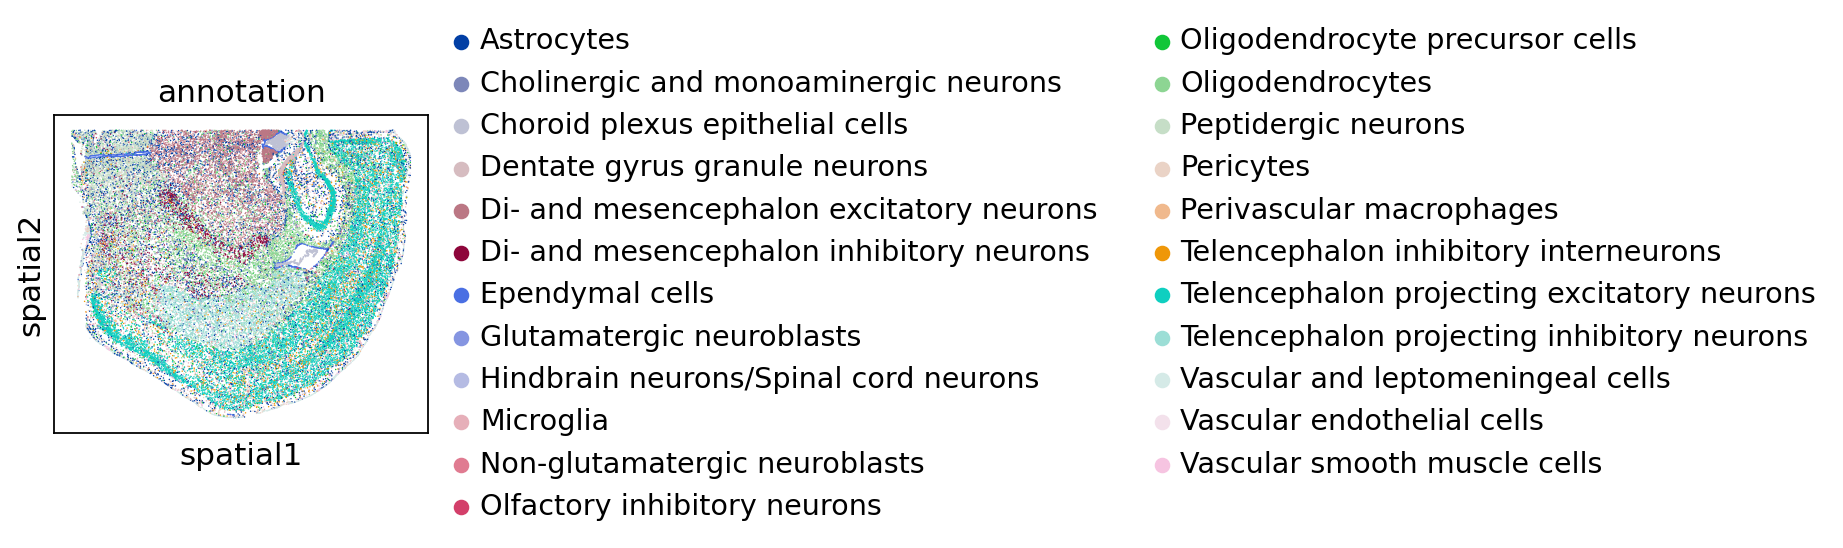

In [129]:
#--- cell_bin data
adata_cellbin.obs['annotation'] = adata_cellbin.obs['annotation'].astype(str).astype('category')

# Default colorization
sc.set_figure_params(figsize=(3,6), facecolor="white", dpi_save=300)
sc.pl.spatial(adata_cellbin, color="annotation", spot_size=135)

# Get the above (default) color palette
palette_default = adata_cellbin.uns['annotation_colors'].copy()
sns.palplot(palette_default)

## Figure2A-2 random plot with Scanpy (Squidpy)

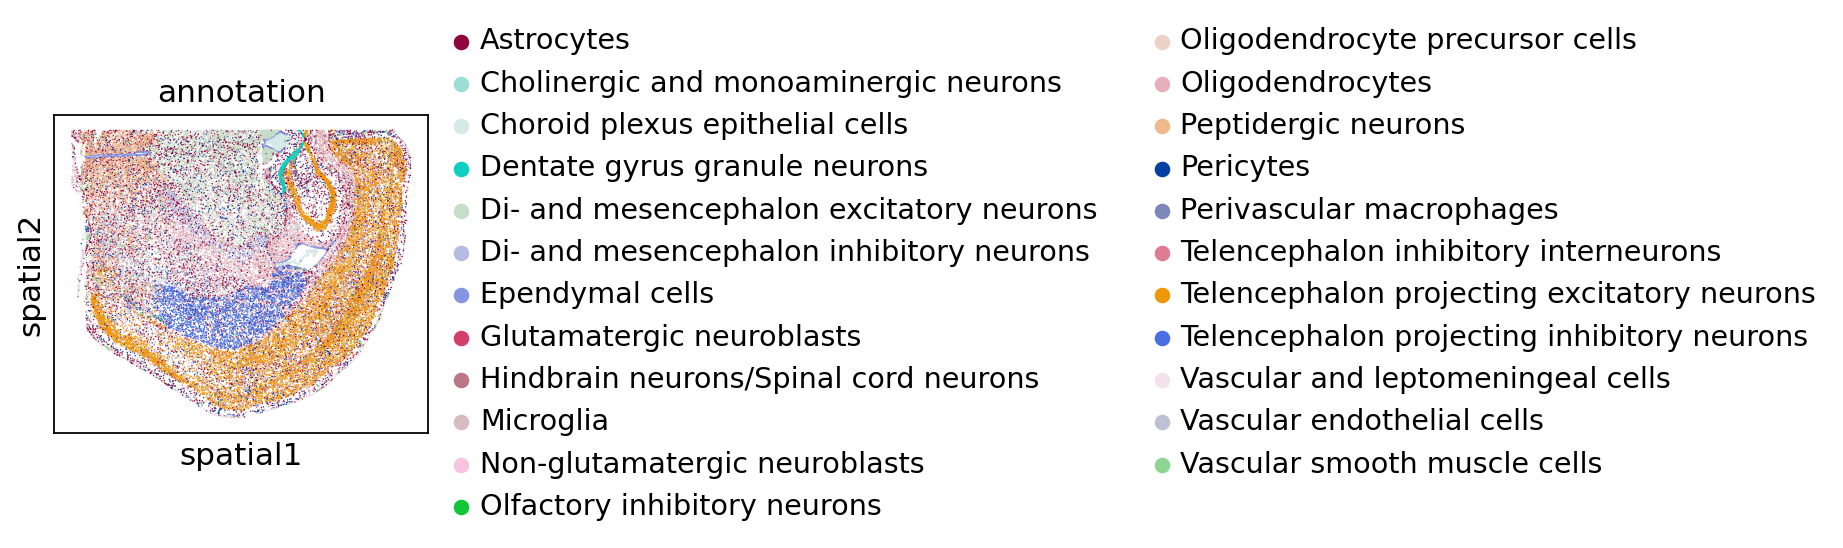

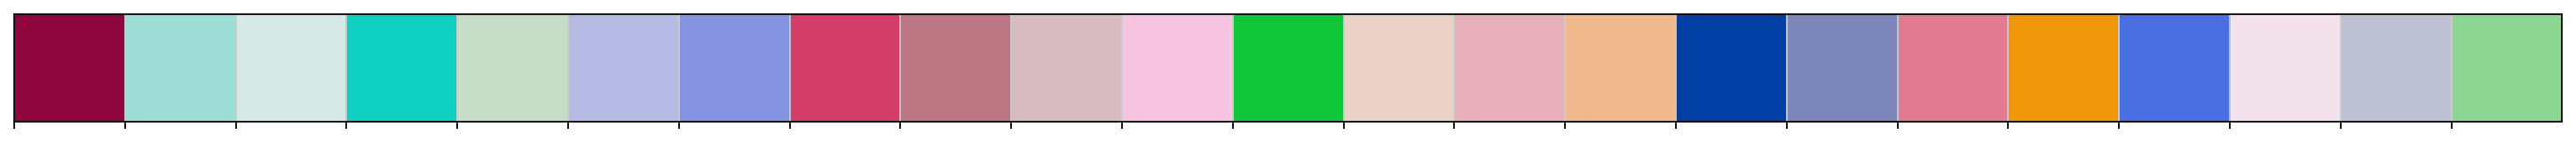

In [7]:
# Random palette
palette_random = palette_default.copy()
np.random.seed(123)
np.random.shuffle(palette_random)
sc.pl.spatial(adata_cellbin, color="annotation", spot_size=135, palette=palette_random)#, save="Figure3B_scanpy_random.pdf")
sns.palplot(palette_random)

## Figure2A-3 default plot with palo

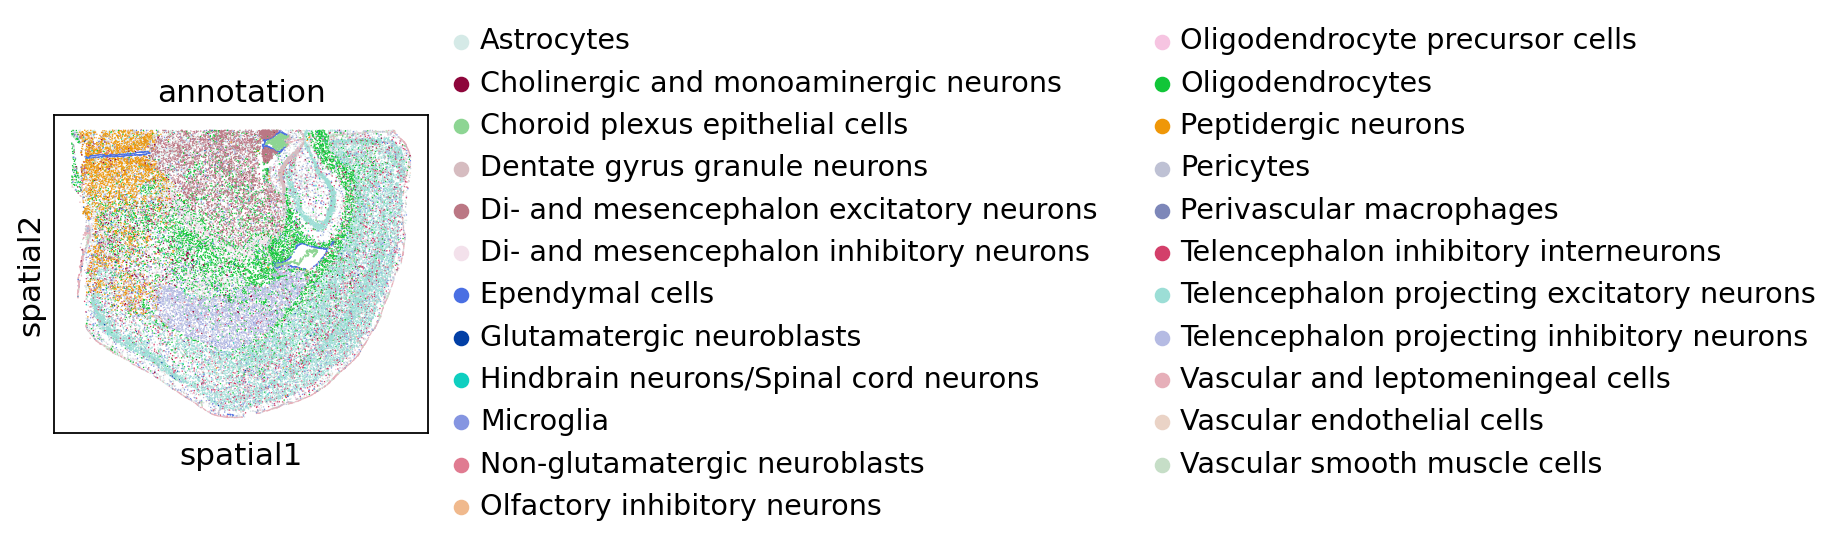

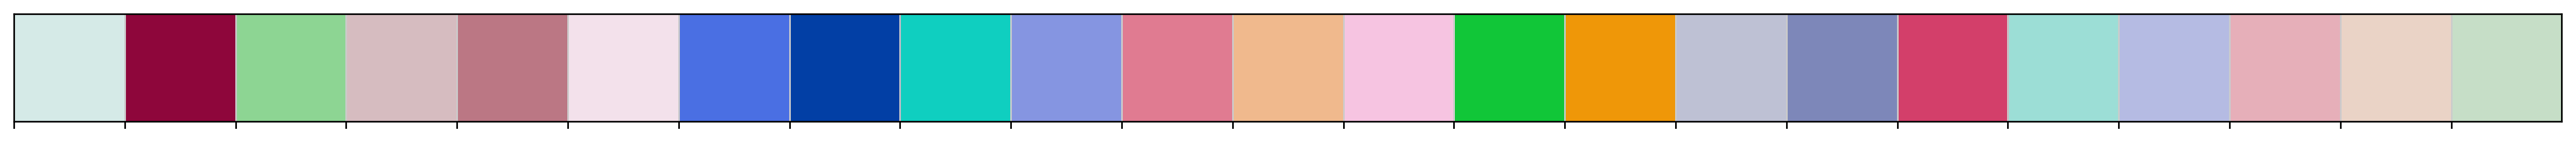

In [8]:
import os
os.environ['R_HOME'] = '/home/jingzh/.conda/envs/spaco_dev/lib/R'

from rpy2.robjects.packages import importr
from rpy2 import robjects
palo = importr("Palo")
base = importr("base")

r = robjects.r
set_seed = r('set.seed')
set_seed(int(123))

r_coor = robjects.r.matrix(
    robjects.FloatVector(adata_cellbin.obsm['spatial'].ravel()),
    nrow=len(adata_cellbin),
    byrow=True
)

try:
    palopal = palo.Palo(r_coor,adata_cellbin.obs['annotation'].to_list(),robjects.StrVector(palette_default))
    palo_mapping = dict(zip(list(base.names(palopal)), pd.DataFrame(palopal)[0].to_list()))
    palette_palo = [palo_mapping[i] for i in sorted(palo_mapping.keys())]
except:
    palette_palo = palette_default.copy()

sc.pl.spatial(adata_cellbin, color="annotation", spot_size=135, palette=palette_palo)#, save="Figure3B_palo.pdf")
sns.palplot(palette_palo)


## Figure2A-4 Spaco assignment

In [9]:
cig_graph = spaco.distance.spatial_distance(
    cell_coordinates=adata_cellbin.obsm['spatial'],
    cell_labels=adata_cellbin.obs['annotation'],
    radius=200,
    n_neighbors=30,
    n_cells=3,
)

cig_graph_tmp = cig_graph.copy()
cig_graph_tmp['index'] = cig_graph_tmp.index
#cig_graph_tmp.melt(id_vars=['index']).to_csv("cig.csv")

|-----------> Calculating cell neighborhood...
|-----------> Filtering out neighborhood outliers...
|-----------> Calculating cluster interlacement score...
|-----------> Constructing cluster interlacement graph...


|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


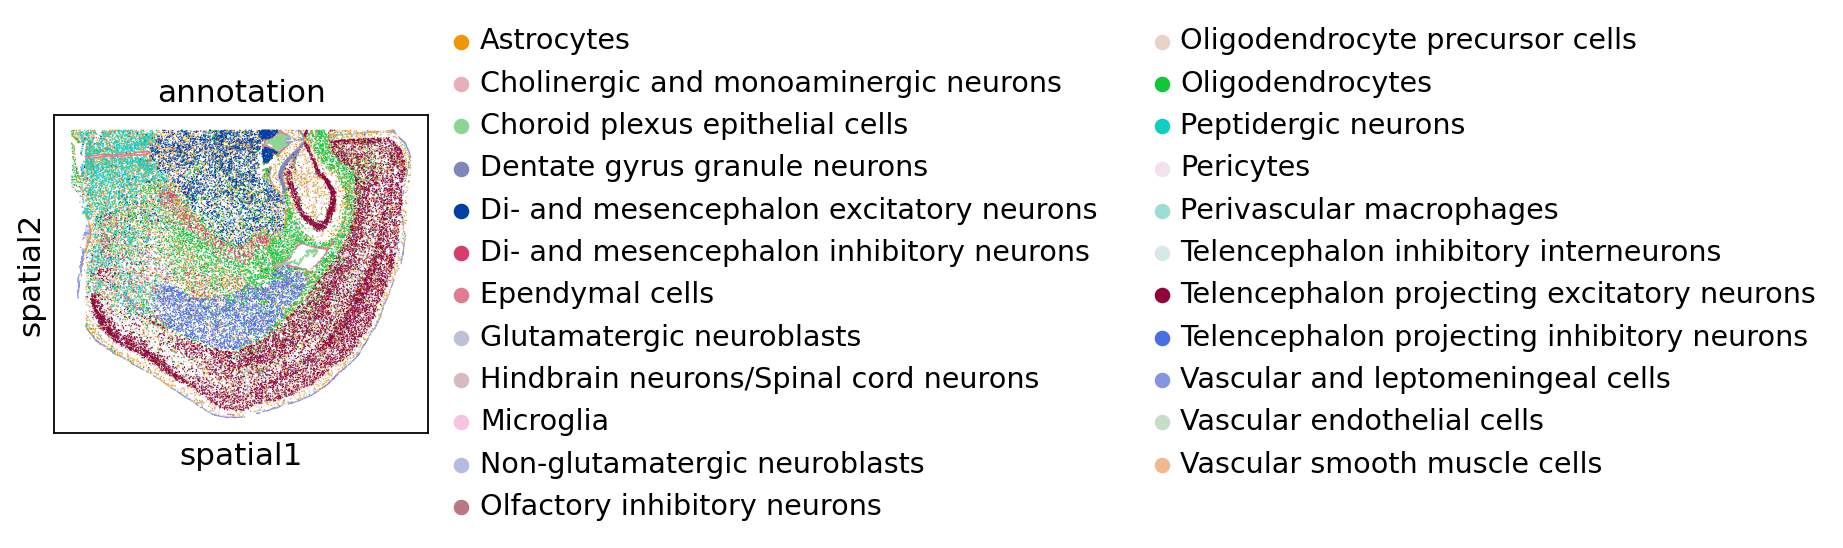

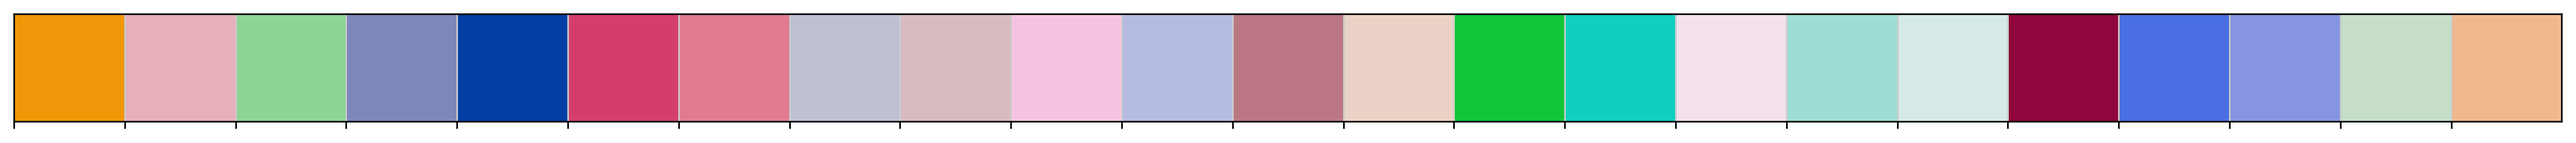

In [10]:
color_mapping = spaco.mapping.map_graph(cig_graph,spaco.distance.perceptual_distance(palette_default), 
                                        distance_metric="mul_1", random_max_iter=5000)

color_mapping = {k: color_mapping[k] for k in adata_cellbin.obs['annotation'].cat.categories}

# Set new colors for adata
palette_spaco = list(color_mapping.values())

# Spaco colorization
sc.pl.spatial(adata_cellbin, color="annotation", spot_size=135, palette=palette_spaco)#, save="Figure3A_spaco.pdf")
sns.palplot(palette_spaco)

In [11]:
#cluster = adata_cellbin.obs['annotation'].unique().to_list()

In [12]:
#cluster2 = [cluster[n].replace("/", " ") for n in range(len(cluster))]

In [13]:
#for i in range(len(cluster)):
#    sc.pl.spatial(adata_cellbin, color="annotation", spot_size=135, palette=np.repeat('#FF0000',len(cluster)).tolist(), groups=cluster[i], 
#                 save="cluster_split_figures_groundtruth/" + cluster2[i] + ".pdf")

## Figure2C Red mean metric boxplot

In [14]:
cellpair =pd.read_csv("./cell_pairs_cpd.csv")

In [15]:
cell_labels = np.unique(adata_cellbin.obs['annotation'])
color_mapping_default = {cell_labels[k]:palette_default[k] for k in range(len(cell_labels))}
color_mapping_random = {cell_labels[k]:palette_random[k] for k in range(len(cell_labels))}
color_mapping_palo = {cell_labels[k]:palette_palo[k] for k in range(len(cell_labels))}
#color_mapping_umap = {palette_umap[k]:cell_labels[k] for k in range(len(cell_labels))}
color_mapping_spaco = {cell_labels[k]:palette_spaco[k] for k in range(len(cell_labels))}

In [16]:
spaco_color = pd.DataFrame(color_mapping_spaco, index=[0]).T
palo_color = pd.DataFrame(color_mapping_palo, index=[0]).T
random_color = pd.DataFrame(color_mapping_random, index=[0]).T
default_color = pd.DataFrame(color_mapping_default, index=[0]).T

In [17]:
cellpair['spaco_col1'] = "a"
cellpair['spaco_col2'] = "b"
cellpair['palo_col1'] = "a"
cellpair['palo_col2'] = "b"
cellpair['random_col1'] = "a"
cellpair['random_col2'] = "b"
cellpair['default_col1'] = "a"
cellpair['default_col2'] = "b"
cell_labels1 = cellpair['names'].to_list()
cell_labels2 = cellpair['variable'].to_list()
for k in range(len(cell_labels1)):
    cellpair.loc[k, 'spaco_col1'] = spaco_color.loc[cell_labels1[k], 0]
    cellpair.loc[k, 'palo_col1'] = palo_color.loc[cell_labels1[k], 0]
    cellpair.loc[k, 'random_col1'] = random_color.loc[cell_labels1[k], 0]
    cellpair.loc[k, 'default_col1'] = default_color.loc[cell_labels1[k], 0]
for k in range(len(cell_labels2)):
    cellpair.loc[k, 'spaco_col2'] = spaco_color.loc[cell_labels2[k], 0]
    cellpair.loc[k, 'palo_col2'] = palo_color.loc[cell_labels2[k], 0]
    cellpair.loc[k, 'random_col2'] = random_color.loc[cell_labels2[k], 0]
    cellpair.loc[k, 'default_col2'] = default_color.loc[cell_labels2[k], 0]

In [18]:
spaco_cpd = spaco.distance.perceptual_distance(palette_spaco)
spaco_cpd_tmp = spaco_cpd.copy()
spaco_cpd_tmp['index'] = spaco_cpd_tmp.index
spaco_cpd_tmp.melt(id_vars=['index']).to_csv("spaco_color_perceptual_differences.csv")
cellpair['spaco_cpd'] = 0
for i in range(cellpair.shape[0]):
    cellpair.loc[i, "spaco_cpd"] = spaco_cpd.loc[cellpair.loc[i,"spaco_col1"],cellpair.loc[i,"spaco_col2"]]

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


In [19]:
palo_cpd = spaco.distance.perceptual_distance(palette_palo)
palo_cpd_tmp = palo_cpd.copy()
palo_cpd_tmp['index'] = palo_cpd_tmp.index
palo_cpd_tmp.melt(id_vars=['index']).to_csv("palo_color_perceptual_differences.csv")
cellpair['palo_cpd'] = 0
for i in range(cellpair.shape[0]):
    cellpair.loc[i, "palo_cpd"] = palo_cpd.loc[cellpair.loc[i,"palo_col1"],cellpair.loc[i,"palo_col2"]]

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


In [20]:
random_cpd = spaco.distance.perceptual_distance(palette_random)
random_cpd_tmp = spaco_cpd.copy()
random_cpd_tmp['index'] = random_cpd_tmp.index
random_cpd_tmp.melt(id_vars=['index']).to_csv("random_color_perceptual_differences.csv")
cellpair['random_cpd'] = 0
for i in range(cellpair.shape[0]):
    cellpair.loc[i, "random_cpd"] = random_cpd.loc[cellpair.loc[i,"random_col1"],cellpair.loc[i,"random_col2"]]

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


In [21]:
default_cpd = spaco.distance.perceptual_distance(palette_default)
default_cpd_tmp = default_cpd.copy()
default_cpd_tmp['index'] = default_cpd_tmp.index
default_cpd_tmp.melt(id_vars=['index']).to_csv("default_color_perceptual_differences.csv")
cellpair['default_cpd'] = 0
for i in range(cellpair.shape[0]):
    cellpair.loc[i, "default_cpd"] = default_cpd.loc[cellpair.loc[i,"default_col1"],cellpair.loc[i,"default_col2"]]

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...


In [22]:
cellpair.to_csv("all_cpd.csv")

In [23]:
cpd = cellpair.loc[:,['spaco_cpd','palo_cpd', 'random_cpd','default_cpd']].copy().melt()

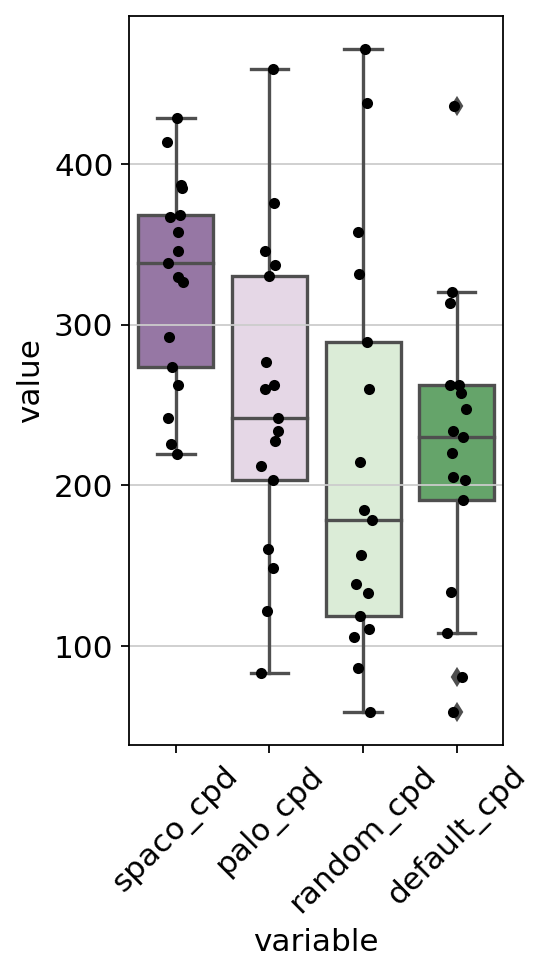

In [32]:
plt.figure()
fig = sns.boxplot(x="variable", y="value", data=cpd, palette="PRGn") 
fig = sns.stripplot(x = "variable", y = "value", color = 'black', dodge=True,
                      data = cpd)
plt.xticks(rotation=45)
plt.savefig("Figure3D_compare_boxplot.pdf")

In [27]:
stats.wilcoxon(cellpair['spaco_cpd'], cellpair['palo_cpd'],correction=True,alternative='greater')

/home/jingzh/.conda/envs/spaco_dev/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


WilcoxonResult(statistic=119.0, pvalue=0.00451003098471673)

In [28]:
stats.wilcoxon(cellpair['spaco_cpd'], cellpair['random_cpd'],correction=True,alternative='greater')

WilcoxonResult(statistic=134.0, pvalue=0.0023193359375)

In [29]:
stats.wilcoxon(cellpair['spaco_cpd'], cellpair['default_cpd'],correction=True,alternative='greater')

WilcoxonResult(statistic=146.0, pvalue=0.00014495849609375)

## Figure2D

In [33]:
score = pd.read_csv("./score.CSV")

In [37]:
score = score.melt()

In [39]:
score.columns = ['method', 'score']

In [42]:
score

method  score
0     Palo      5
1     Palo      1
2     Palo      8
3     Palo      8
4     Palo      7
..     ...    ...
95  Random      7
96  Random      9
97  Random      8
98  Random      5
99  Random      6

[100 rows x 2 columns]

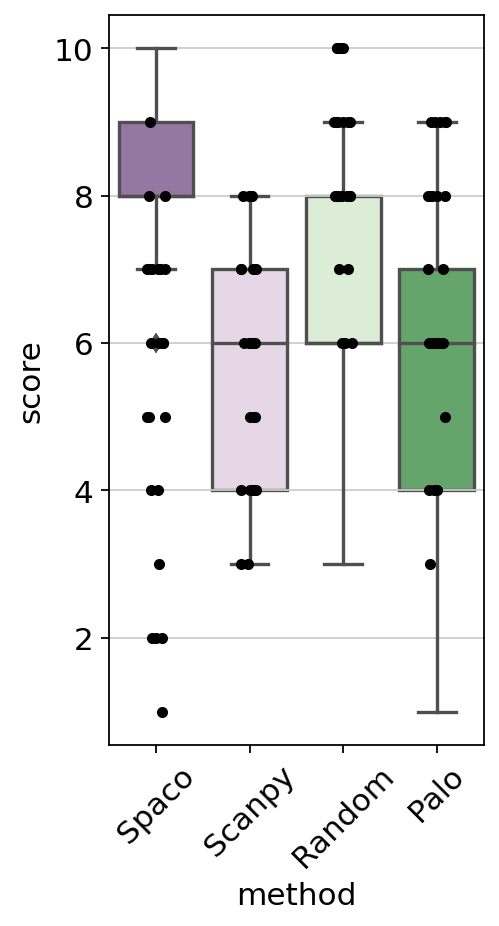

In [43]:
plt.figure()
fig = sns.boxplot(x="method", y="score", data=score, palette="PRGn",order=["Spaco", "Scanpy", "Random","Palo"]) 
fig = sns.stripplot(x = "method", y = "score", color = 'black', dodge=True,
                      data = score)
plt.xticks(rotation=45)
plt.savefig("Figure2D_score_boxplot.pdf")

## Figure2F,Gcut into micro-squares; Supplementary Figure1A 

In [44]:
min(adata_cellbin.obsm['spatial'][:,0]), max(adata_cellbin.obsm['spatial'][:,0])

(83.5, 31940.4893617021)

In [45]:
min(adata_cellbin.obsm['spatial'][:,1]), max(adata_cellbin.obsm['spatial'][:,1])

(32.0133333333333, 27047.3279352227)

In [68]:
adata = adata_cellbin.copy()
df = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, 
                columns=np.array(['spatial_x', 'spatial_y']))
adata.obs['spatial_x'], adata.obs['spatial_y']  = df['spatial_x'], df['spatial_y']
x_range = range_float(adata.obs['spatial_x'].min(), adata.obs['spatial_x'].max(), 2500)
y_range = range_float(adata.obs['spatial_y'].min(), adata.obs['spatial_y'].max(), 2500)
x_range[-1] = x_range[-1] + 1e-5
y_range[-1] = y_range[-1] + 1e-5     


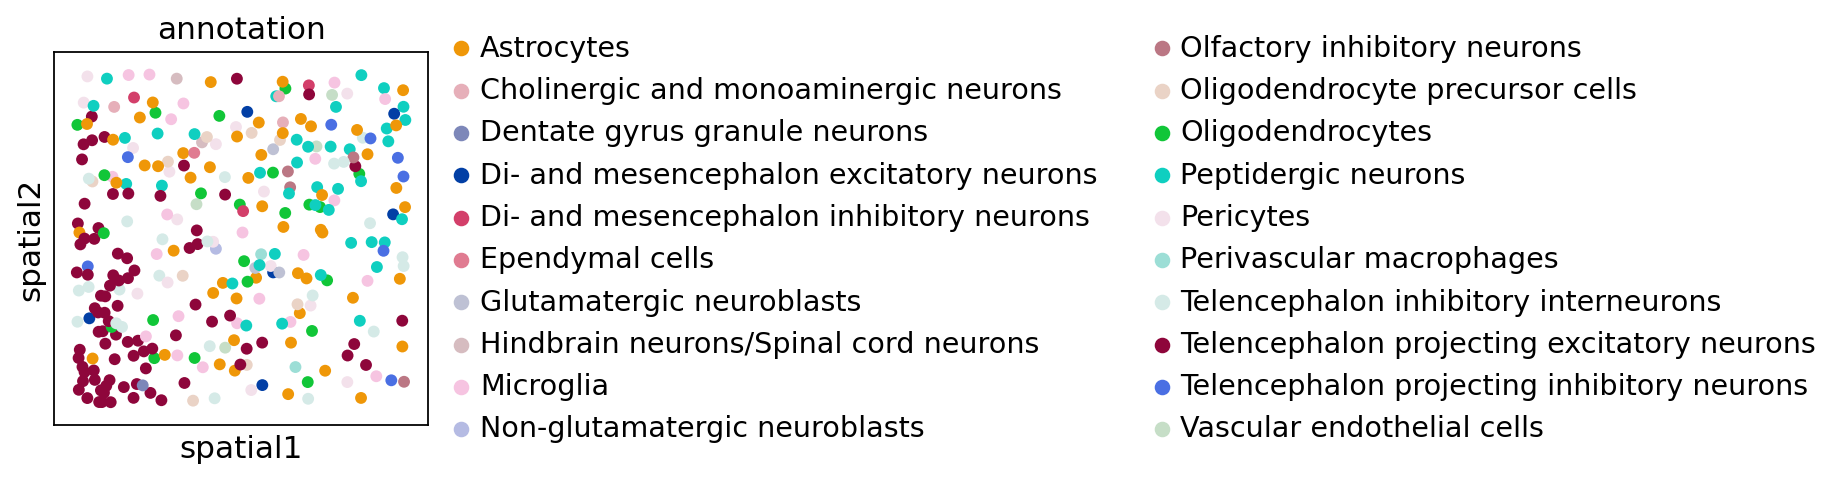

In [69]:

i = 1
j = 6
bdata = adata[(adata.obs['spatial_x'] >= x_range[i]) & (adata.obs['spatial_x'] < x_range[i+1]) &
                (adata.obs['spatial_y'] >= y_range[j]) & (adata.obs['spatial_y'] < y_range[j+1])
              ]
sc.pl.spatial(bdata, color="annotation", spot_size=90, save="Figure3H_high.pdf")

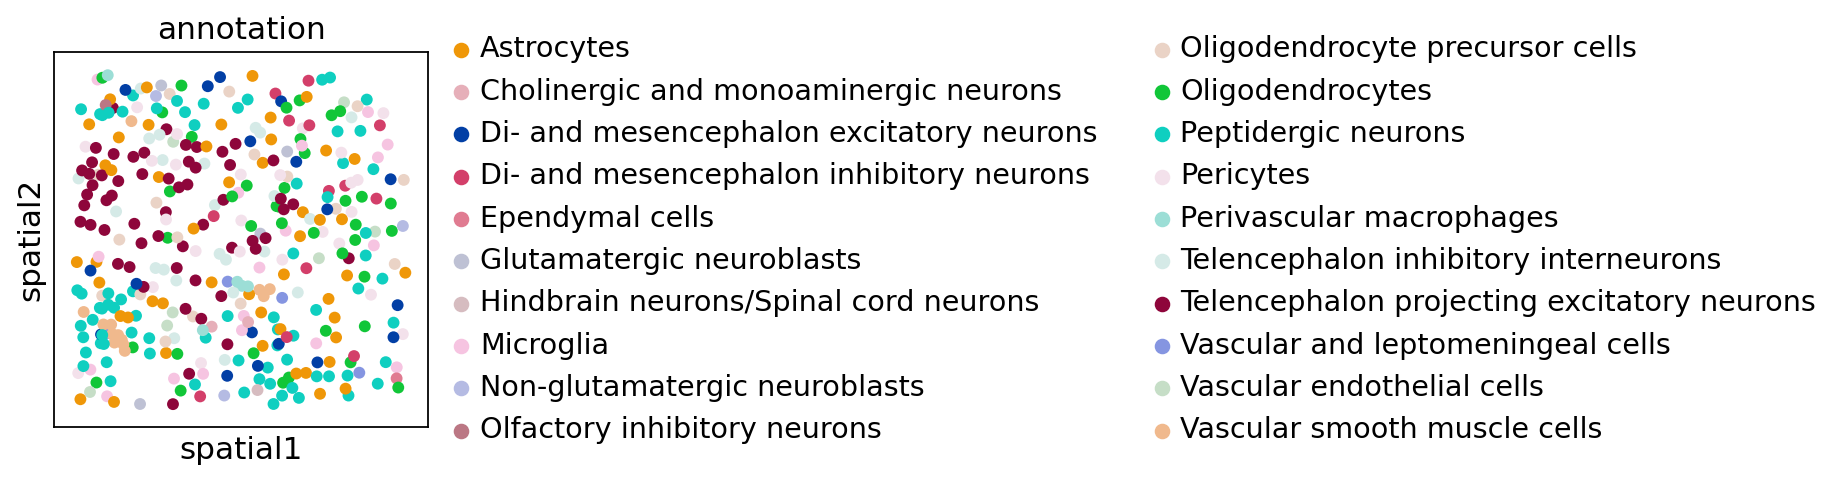

In [70]:

i = 1
j = 5
bdata = adata[(adata.obs['spatial_x'] >= x_range[i]) & (adata.obs['spatial_x'] < x_range[i+1]) &
                (adata.obs['spatial_y'] >= y_range[j]) & (adata.obs['spatial_y'] < y_range[j+1])
              ]
sc.pl.spatial(bdata, color="annotation", spot_size=90, save="Figure3I_high.pdf")

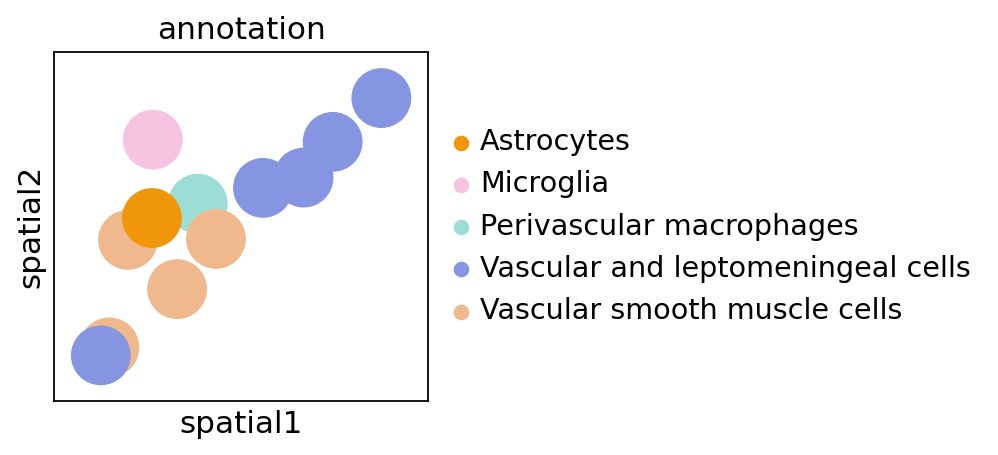

In [91]:

i = 10
j = 9
bdata = adata[(adata.obs['spatial_x'] >= x_range[i]) & (adata.obs['spatial_x'] < x_range[i+1]) &
                (adata.obs['spatial_y'] >= y_range[j]) & (adata.obs['spatial_y'] < y_range[j+1])
              ]
sc.pl.spatial(bdata, color="annotation", spot_size=90, save="Figure3I_high.pdf")

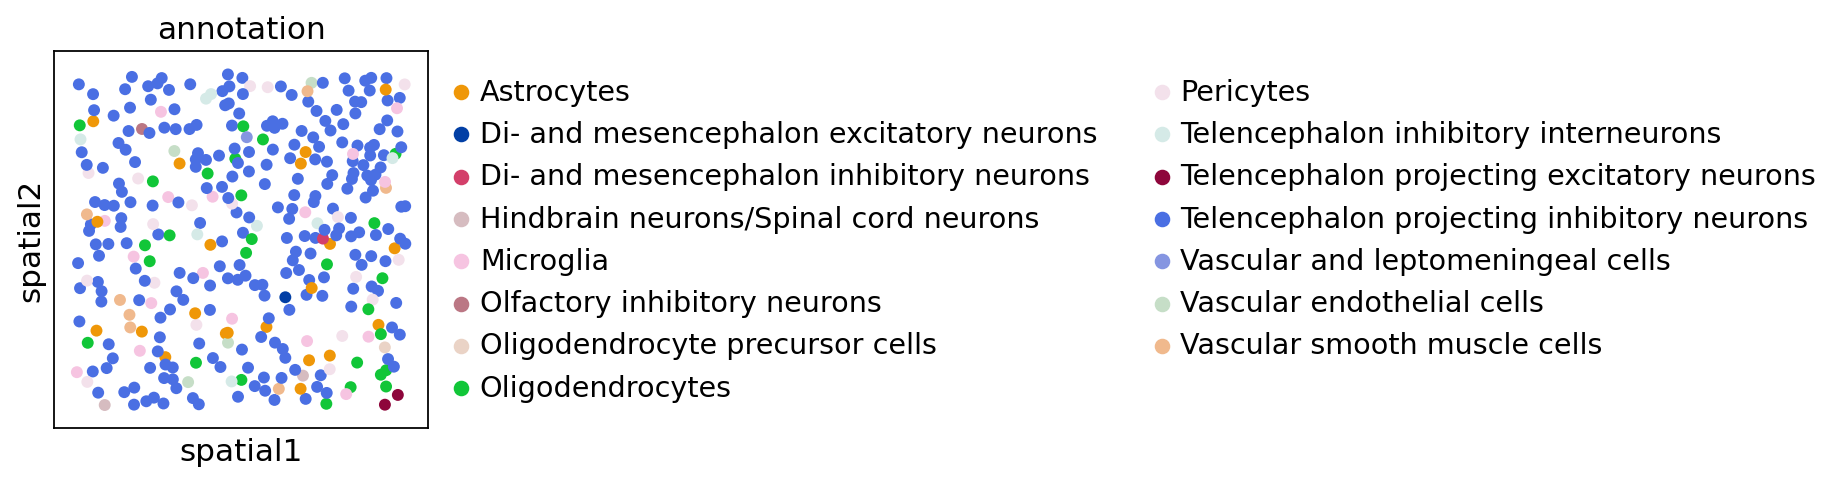

In [92]:

i = 6
j = 7
bdata = adata[(adata.obs['spatial_x'] >= x_range[i]) & (adata.obs['spatial_x'] < x_range[i+1]) &
                (adata.obs['spatial_y'] >= y_range[j]) & (adata.obs['spatial_y'] < y_range[j+1])
              ]
sc.pl.spatial(bdata, color="annotation", spot_size=90, save="Figure3I_high.pdf")

In [71]:
def range_float(start, stop, interv):
  return [round(start + float(i) * interv, 2) for i in range(int((stop - start) / (float(interv))) + 1)]

def _boxplot_block(adata, color_mapping_default, color_mapping_random, color_mapping_spaco, 
                   palette_default, palette_random, palette_spaco, mean_value, mean_group, r = 90, n = 16):

  min_cells=0
  unique_tmp = np.unique(adata.obs['annotation'],return_counts=True)
  adata = adata[adata.obs['annotation'].isin(unique_tmp[0][unique_tmp[1]>min_cells])].copy()

  adata = adata[adata.obs['annotation']!="Unannotated"].copy() 
  
  weight_mat = np.matmul(np.matrix(np.unique(adata.obs['annotation'], return_counts=True)[1]).T,np.matrix(np.unique(adata.obs['annotation'], return_counts=True)[1]))
  
  #cd_list_default = spaco.distance.perceptual_distance(palette_default).to_numpy()[cig_graph_crop!=0]
  cd_list_default = spaco.distance.perceptual_distance(palette_default)
  cd_list_default.index = cd_list_default.columns.map(color_mapping_default)
  cd_list_default.columns = cd_list_default.index.tolist()
  print(len(np.unique(adata.obs['annotation'])))
  cd_list_default = cd_list_default.loc[np.unique(adata.obs['annotation']), np.unique(adata.obs['annotation'])]
  cd_list_default = np.multiply(np.matrix(cd_list_default), weight_mat)
  #cd_list_default = cd_list_default.to_numpy()
  mean_value.append(np.sum(cd_list_default)/np.sum(weight_mat))
  #mean_value.append(np.mean(cd_list_default))
  mean_group.append("default")

  
  #cd_list_random = spaco.distance.perceptual_distance(palette_random).to_numpy()[cig_graph_crop!=0]
  cd_list_random = spaco.distance.perceptual_distance(palette_random)
  cd_list_random.index = cd_list_random.columns.map(color_mapping_random)
  cd_list_random.columns = cd_list_random.index.tolist()
  cd_list_random = cd_list_random.loc[np.unique(adata.obs['annotation']), np.unique(adata.obs['annotation'])]
  cd_list_random = np.multiply(np.matrix(cd_list_random), weight_mat)
  #cd_list_random = cd_list_random.to_numpy()
  mean_value.append(np.sum(cd_list_random)/np.sum(weight_mat))
  #mean_value.append(np.mean(cd_list_random))
  mean_group.append("random")

  #cd_list_random = spaco.distance.perceptual_distance(palette_random).to_numpy()[cig_graph_crop!=0]
  cd_list_palo = spaco.distance.perceptual_distance(palette_palo)
  cd_list_palo.index = cd_list_palo.columns.map(color_mapping_palo)
  cd_list_palo.columns = cd_list_palo.index.tolist()
  cd_list_palo = cd_list_palo.loc[np.unique(adata.obs['annotation']), np.unique(adata.obs['annotation'])]
  cd_list_palo = np.multiply(np.matrix(cd_list_palo), weight_mat)
  #cd_list_random = cd_list_random.to_numpy()
  mean_value.append(np.sum(cd_list_palo)/np.sum(weight_mat))
  #mean_value.append(np.mean(cd_list_random))
  mean_group.append("palo")

  #cd_list_spaco = spaco.distance.perceptual_distance(palette_spaco).to_numpy()[cig_graph_crop!=0]
  cd_list_spaco = spaco.distance.perceptual_distance(palette_spaco)
  cd_list_spaco.index = cd_list_spaco.columns.map(color_mapping_spaco)
  cd_list_spaco.columns = cd_list_spaco.index.tolist()
  cd_list_spaco = cd_list_spaco.loc[np.unique(adata.obs['annotation']), np.unique(adata.obs['annotation'])]
  cd_list_spaco = np.multiply(np.matrix(cd_list_spaco), weight_mat)
  #cd_list_spaco = cd_list_spaco.to_numpy()
  mean_value.append(np.sum(cd_list_spaco)/np.sum(weight_mat))
  #mean_value.append(np.mean(cd_list_spaco))
  mean_group.append("spaco")

def _block(adata, color_mapping_default, color_mapping_random, color_mapping_spaco, 
           palette_default, palette_random, palette_spaco, r=5, n=16, interv = 1000):
  import matplotlib.pyplot as plt

  df = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, 
                    columns=np.array(['spatial_x', 'spatial_y']))
  adata.obs['spatial_x'], adata.obs['spatial_y']  = df['spatial_x'], df['spatial_y']
  x_range = range_float(adata.obs['spatial_x'].min(), adata.obs['spatial_x'].max(), interv)
  y_range = range_float(adata.obs['spatial_y'].min(), adata.obs['spatial_y'].max(), interv)
  x_range[-1] = x_range[-1] + 1e-5
  y_range[-1] = y_range[-1] + 1e-5
  steps_x = int((adata.obs['spatial_x'].max() - adata.obs['spatial_x'].min()) / (float(interv)))
  steps_y = int((adata.obs['spatial_y'].max() - adata.obs['spatial_y'].min()) / (float(interv)))
  fig, ax = plt.subplots(steps_y+1, steps_x+1)
  mean_value = []
  mean_group = []
  num_i = []
  num_j = []

  for i in range(len(x_range) - 1):
    for j in range(len(y_range) - 1):
      bdata = adata[(adata.obs['spatial_x'] >= x_range[i]) & (adata.obs['spatial_x'] < x_range[i+1]) &
                    (adata.obs['spatial_y'] >= y_range[j]) & (adata.obs['spatial_y'] < y_range[j+1])
                  ]
      if (len(bdata) < 2):
        continue
      #return bdata
      sc.pl.spatial(bdata, color="annotation", spot_size=135, frameon=False, img_key=None,
                    legend_loc=None, title='', show=False, ax=ax[j][i])
      _boxplot_block(bdata, color_mapping_default, color_mapping_random, color_mapping_spaco, 
                     palette_default, palette_random, palette_spaco, mean_value, mean_group, r=r, n=n)
      num_i.append(i)
      num_i.append(i)
      num_i.append(i)
      num_i.append(i)
      num_j.append(j)
      num_j.append(j)
      num_j.append(j)
      num_j.append(j)
  plt.show()

  df_color_mean = pd.DataFrame({"color difference":mean_value, "group":mean_group, "num_i":num_i, "num_j":num_j})
  return df_color_mean
  #plt.figure()
  #fig = sns.boxplot(x="group", y="color difference", data=df_color_mean[df_color_mean.mean_value!=0], palette="PRGn") 
  #fig = sns.stripplot(x = "group", y = "color difference", color = 'black', dodge=True,
  #                      data = df_color_mean[df_color_mean.mean_value!=0])
  


In [72]:
cell_labels = np.unique(adata_cellbin.obs['annotation'])
color_mapping_default = {palette_default[k]:cell_labels[k] for k in range(len(cell_labels))}
color_mapping_random = {palette_random[k]:cell_labels[k] for k in range(len(cell_labels))}
color_mapping_palo = {palette_palo[k]:cell_labels[k] for k in range(len(cell_labels))}
#color_mapping_umap = {palette_umap[k]:cell_labels[k] for k in range(len(cell_labels))}
color_mapping_spaco = {palette_spaco[k]:cell_labels[k] for k in range(len(cell_labels))}

|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
20
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
19
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
|-----------> Calculating color perceptual distance...
|-----------> Constructing color distance graph...
18
|-----------> Calculating color perce

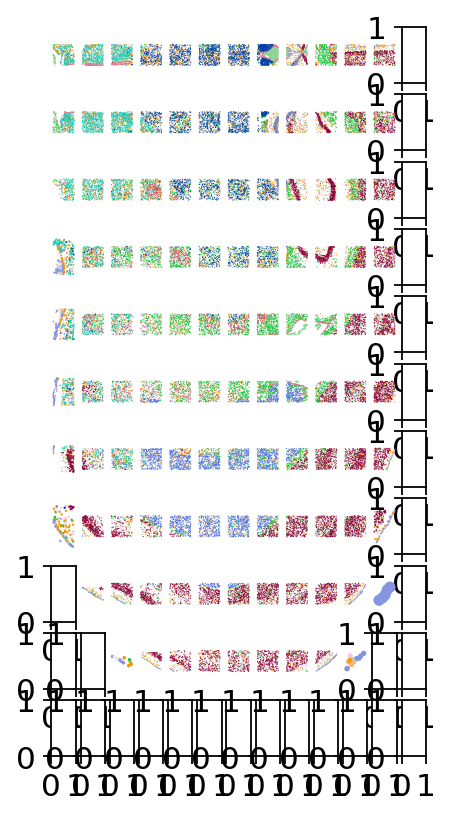

''

In [73]:
df_plt = _block(adata_cellbin, color_mapping_default, color_mapping_random, color_mapping_spaco,
       palette_default, palette_random, palette_spaco, r=5, n=5, interv=2500)

In [74]:
df_plt = df_plt[df_plt['color difference']!=0]
df_plt = df_plt[~np.isnan(df_plt['color difference'])]
df_plt

color difference    group  num_i  num_j
0          219.436621  default      0      0
1          207.004094   random      0      0
2          247.923353     palo      0      0
3          258.610267    spaco      0      0
4          208.456022  default      0      1
..                ...      ...    ...    ...
455        272.009962    spaco     11      6
456        250.704272  default     11      7
457        274.006095   random     11      7
458        132.666323     palo     11      7
459        275.103036    spaco     11      7

[460 rows x 4 columns]

In [75]:
df_plt.to_csv("./squares_cpd.csv")

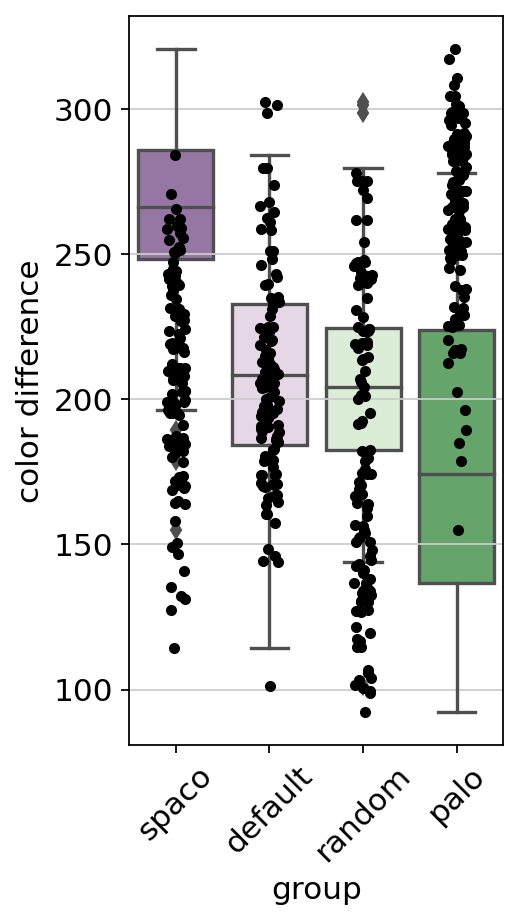

In [80]:
import matplotlib.pyplot as plt
plt.figure()
fig = sns.boxplot(x="group", y="color difference", data=df_plt, palette="PRGn",order=["spaco", "default", "random","palo"]) 
fig = sns.stripplot(x = "group", y = "color difference", color = 'black', dodge=True,
                      data = df_plt)
plt.xticks(rotation=45)
plt.savefig("Figure3G_squares_compare_boxplot.pdf")

In [81]:
df_plt = pd.read_csv("./squares_cpd.csv", index_col=0)

In [82]:
df_plt['num'] = df_plt['num_i'] *10 + df_plt['num_j']

In [85]:
df = df_plt.loc[:,['group', 'color difference', 'num']].pivot(columns="group", index = "num")

In [87]:
stats.wilcoxon(df['color difference']['spaco'], df['color difference']['palo'],correction=True,alternative='greater')

WilcoxonResult(statistic=6659.0, pvalue=8.874761110885113e-21)

In [89]:
stats.wilcoxon(df['color difference']['spaco'], df['color difference']['default'],correction=True,alternative='greater')

WilcoxonResult(statistic=6661.0, pvalue=8.421926100464728e-21)

In [90]:
stats.wilcoxon(df['color difference']['spaco'], df['color difference']['random'],correction=True,alternative='greater')

WilcoxonResult(statistic=6477.0, pvalue=9.16171594602652e-19)

## Supplementary Figure1B

In [93]:
cig = pd.read_csv("./cig.csv", index_col=0)

In [94]:
cig.sort_values(by="value").tail(10)

index  \
299                                   Astrocytes   
13                              Oligodendrocytes   
14                           Peptidergic neurons   
322                                   Astrocytes   
427                             Oligodendrocytes   
317  Telencephalon projecting excitatory neurons   
414                                   Astrocytes   
18   Telencephalon projecting excitatory neurons   
409  Telencephalon projecting excitatory neurons   
431        Telencephalon inhibitory interneurons   

                                        variable     value  
299                             Oligodendrocytes  3.017606  
13                                    Astrocytes  3.017606  
14                                    Astrocytes  3.127850  
322                          Peptidergic neurons  3.127850  
427  Telencephalon projecting excitatory neurons  3.411608  
317                             Oligodendrocytes  3.411608  
414  Telencephalon projecting excitatory neurons  4.846579  
18                                    Astrocytes  4.846579  
409        Telencephalon inhibitory interneurons  5.041547  
431  Telencephalon projecting excitatory neurons  5.041547

/home/jingzh/.conda/envs/spaco_dev/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


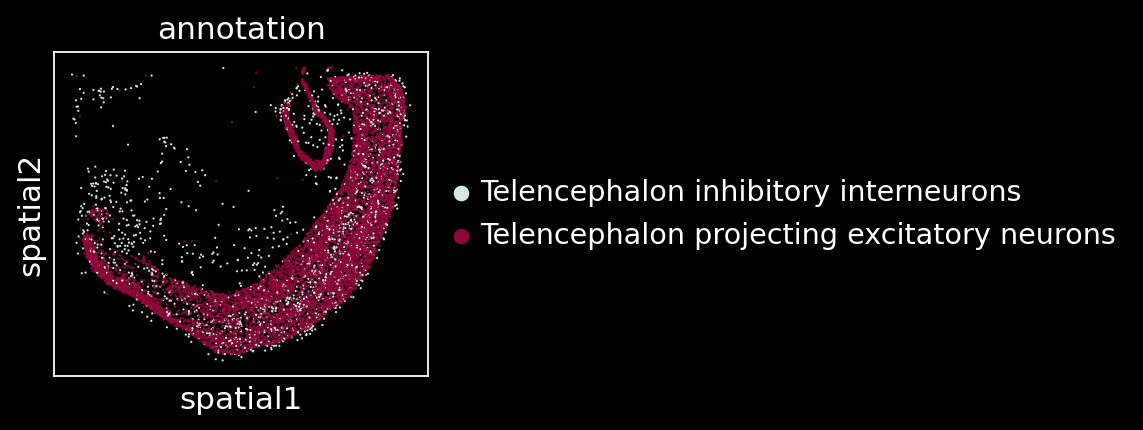

In [101]:
plt.style.use("dark_background")
sc.pl.spatial(adata_cellbin[adata_cellbin.obs['annotation'].isin(cig.sort_values(by="value", ascending=False).iloc[0,0:2].to_list())], color="annotation", spot_size=200,
              palette=['#d5eae7','#8e063b',], groups=cig.sort_values(by="value", ascending=False).iloc[0,0:2].to_list())

/home/jingzh/.conda/envs/spaco_dev/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`


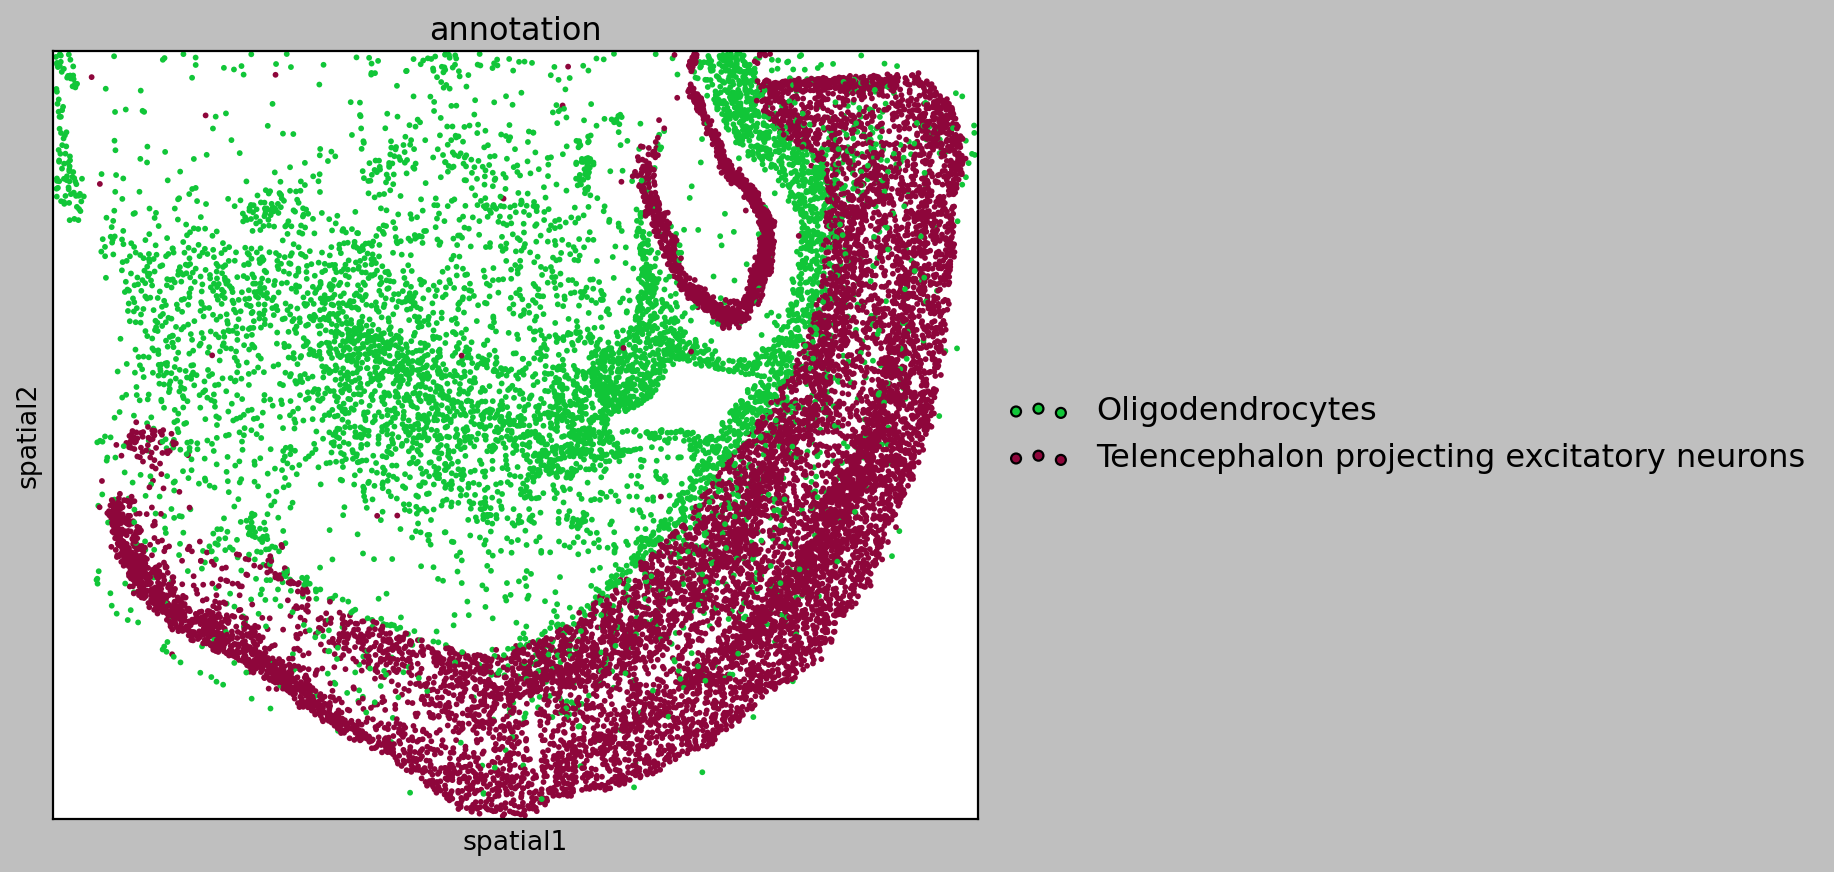

In [105]:
plt.style.use("classic")
sc.pl.spatial(adata_cellbin[adata_cellbin.obs['annotation'].isin(cig.sort_values(by="value", ascending=False).iloc[4,0:2].to_list())], color="annotation", spot_size=200,
              palette=['#11c638','#8e063b',], groups=cig.sort_values(by="value", ascending=False).iloc[4,0:2].to_list(), 
                 save="Figure2J3_CIG_high_scoring_clusters.pdf")

/home/jingzh/.conda/envs/spaco_dev/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


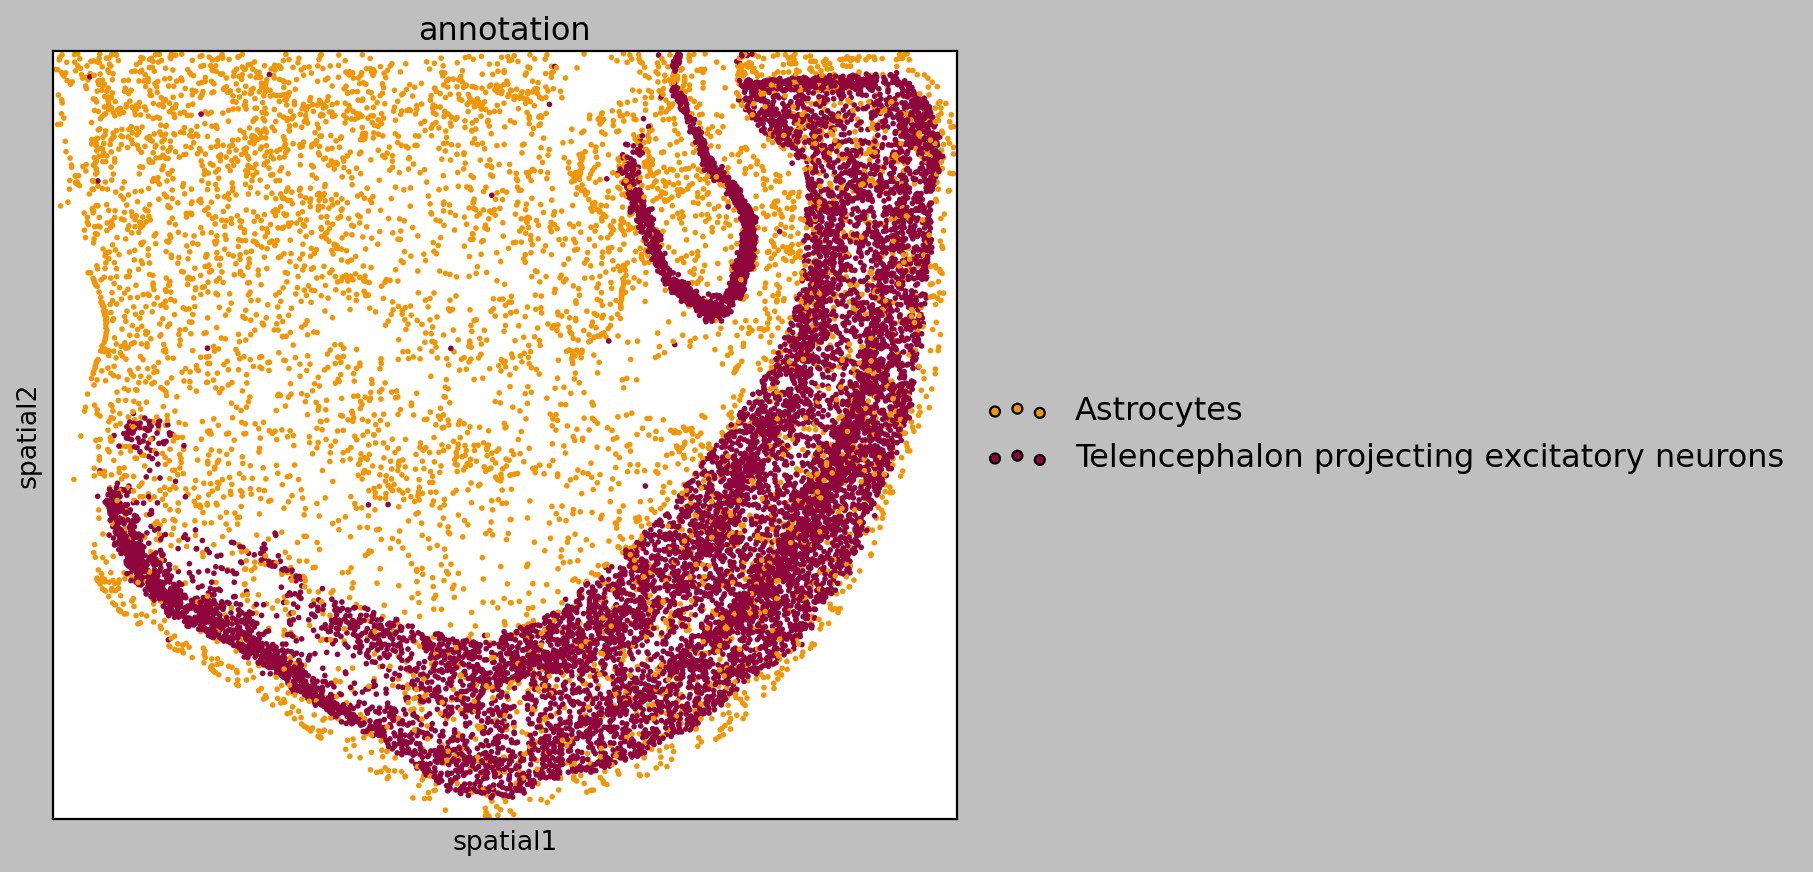

In [106]:
plt.style.use("classic")
sc.pl.spatial(adata_cellbin[adata_cellbin.obs['annotation'].isin(cig.sort_values(by="value", ascending=False).iloc[2,0:2].to_list())], color="annotation", spot_size=200,
              palette=['#ef9708','#8e063b',], groups=cig.sort_values(by="value", ascending=False).iloc[2,0:2].to_list())

## Supplementary Figure1C 

In [107]:
spaco_cpd = pd.read_csv("./spaco_color_perceptual_differences.csv", index_col=0)

In [108]:
cig = pd.read_csv("./cig.csv", index_col=0)

In [109]:
df = pd.concat([cig,spaco_cpd], axis=1)

In [110]:
df.columns = ['cell1','cell2','cig', 'col1','col2','cpd']

In [111]:
df = df[df['cig'] != 0].copy()
df = df[df['cpd'] != 0].copy()

In [112]:
df = df.sort_values(by="cig").reset_index().copy()

In [113]:
df['cig_rank'] = df.index.to_list()

In [114]:
df

index                                        cell1  \
0       55                                    Microglia   
1      209              Choroid plexus epithelial cells   
2      393              Choroid plexus epithelial cells   
3       63        Telencephalon inhibitory interneurons   
4      246                     Perivascular macrophages   
..     ...                                          ...   
443    317  Telencephalon projecting excitatory neurons   
444     18  Telencephalon projecting excitatory neurons   
445    414                                   Astrocytes   
446    431        Telencephalon inhibitory interneurons   
447    409  Telencephalon projecting excitatory neurons   

                                           cell2       cig     col1     col2  \
0                Choroid plexus epithelial cells  0.000205  #f6c4e1  #8dd593   
1                                      Microglia  0.000205  #8dd593  #f6c4e1   
2          Telencephalon inhibitory interneurons  0.000319  #8dd593  #d5eae7   
3                Choroid plexus epithelial cells  0.000319  #d5eae7  #8dd593   
4                  Non-glutamatergic neuroblasts  0.000532  #9cded6  #b5bbe3   
..                                           ...       ...      ...      ...   
443                             Oligodendrocytes  3.411608  #8e063b  #11c638   
444                                   Astrocytes  4.846579  #8e063b  #ef9708   
445  Telencephalon projecting excitatory neurons  4.846579  #ef9708  #8e063b   
446  Telencephalon projecting excitatory neurons  5.041547  #d5eae7  #8e063b   
447        Telencephalon inhibitory interneurons  5.041547  #8e063b  #d5eae7   

           cpd  cig_rank  
0    212.52985         0  
1    212.52985         1  
2    178.82428         2  
3    178.82428         3  
4     83.40552         4  
..         ...       ...  
443  428.46524       443  
444  340.26013       444  
445  340.26013       445  
446  538.17960       446  
447  538.17960       447  

[448 rows x 8 columns]

In [117]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

<Figure size 640x480 with 0 Axes>

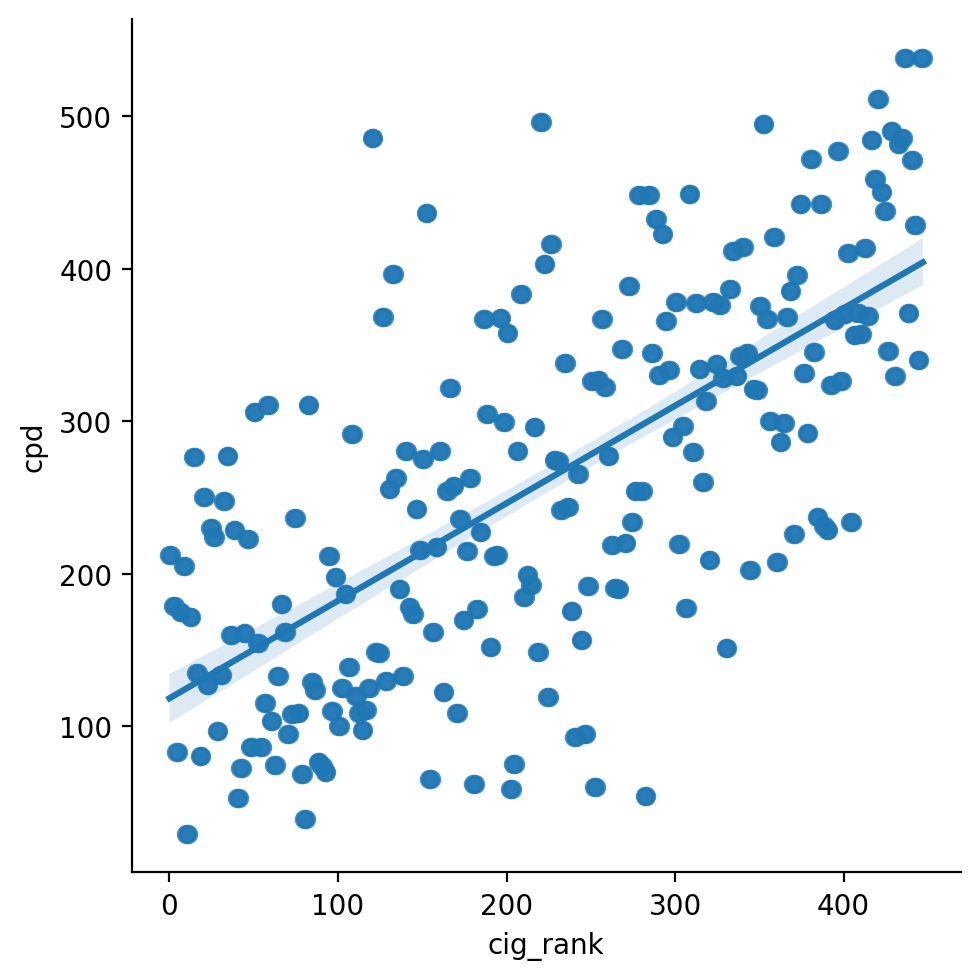

In [122]:
sns.lmplot(data=df, x="cig_rank", y="cpd")
plt.show()

In [1]:
import session_info


session_info.show(excludes=['base'])